# QBOi Tigramite notebook.

First attempt at a shared jupyter notebook.
- Install Tigramite and dependencies
- Load data from Dropbox
- Run Causal Effect Network analysis on QBOi data

All models are loaded, but currently some have errors in the v_flux timeseries.

Warning: Runtime type must be Python 2 (Python 3 not supported by Tigramite)

## Install dependencies and Tigramite
Use pip install to load cython and ace, then use pip install git+... to load tigramite directly from the github repo.

In [3]:
# Install tigramite dependencies
#!pip install -q cython
#!pip install -q ace
#
## Install other python modules
#!pip install netcdf4
#!pip install -U -q PyDrive
#
## Install Tigramite from github
#!pip install git+https://github.com/jakobrunge/tigramite
  

In [4]:
# Imports required python packages
import numpy
import numpy.ma as ma
import matplotlib
from matplotlib import pyplot as plt
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction

import numpy as np
import pandas as pd
import netCDF4
from scipy import signal

# Import packages for PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client to save to google drive
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default() 
#drive = GoogleDrive(gauth)


%matplotlib inline     




Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package


## Load data from Dropbox

I'm not sure if this is the best way to load data, but it's a start. Data is in csv format, the folder is not currently shared, I can give permissions if requested.

Unfortunately the file names aren't informative (i.e. no model, actor names etc.)

Each model has one csv file which contains 8 timeseries, one for each actor, plus a date column.

Note: Once analysis for the project is finalised, it might be good to move data to Figshare, so it has a stable address and DOI.

In [5]:
CAM = "/home/tyrrell/research/qbo/qboi/cen_data/CAM_QBOiExp1_r1i1p1_day.csv"
CCCmaCMAM = "/home/tyrrell/research/qbo/qboi/cen_data/CCCmaCMAM_QBOiExp1_r1i1p1_day.csv"
ISAC_CNRECHAM5sh = "/home/tyrrell/research/qbo/qboi/cen_data/ISAC-CNRECHAM5sh_QBOiExp1_r1i1p1_day.csv"
MIROCMIROC_AGCM = "/home/tyrrell/research/qbo/qboi/cen_data/MIROCMIROC-AGCM_QBOiExp1_r1i1p1_day.csv"
MIROCMIROC_ESM = "/home/tyrrell/research/qbo/qboi/cen_data/MIROCMIROC-ESM_QBOiExp1_r1i1p1_day.csv"
#MOHCUMGA7 = "https://www.dropbox.com/s/vnq57vebl3izq4y/MOHCUMGA7_QBOiExp1_r2i1p1_day.csv"
# MRIMRI_ESM2 = ""
WACCM = "/home/tyrrell/research/qbo/qboi/cen_data/WACCM_QBOiExp1_r1i1p1_day.csv"
# YonseiHadGEM2_A = ""
# YonseiHadGEM2_AC = ""



Read data into Pandas dataframe

In [6]:
cam = pd.read_csv(CAM,index_col=0)
cccmacmam  = pd.read_csv(CCCmaCMAM,index_col=0)
isac_cnrecham5sh = pd.read_csv(ISAC_CNRECHAM5sh,index_col=0)
mirocmiroc_agcm = pd.read_csv(MIROCMIROC_AGCM,index_col=0)
mirocmiroc_esm = pd.read_csv(MIROCMIROC_ESM,index_col=0)
#mohcumga7 = pd.read_csv(MOHCUMGA7,index_col=0)
#mrimri_esm2 = pd.read_csv(MRIMRI_ESM2,index_col=0)
waccm = pd.read_csv(WACCM,index_col=0)
#yonseihadgem2_a = pd.read_csv(YonseiHadGEM2_A,index_col=0)
#yonseihadgem2_ac = pd.read_csv(YonseiHadGEM2_AC,index_col=0)


In [7]:
# Check the data (seem to be quite a few NaN for the v_flux)

print("CAM")
print(cam.head(n=3))
print("CCCMA")
print(cccmacmam.head(n=3))
print("ISAC")
print(isac_cnrecham5sh.head(n=3))
print("MIROC AGCM")
print(mirocmiroc_agcm.head(n=3))
print("MIROC ESM")
print(mirocmiroc_esm.head(n=3))
#print("MOHC")
#print(mohcumga7.head(n=3))
#print("MRI")
#print(mrimri_esm2.head(n=3))
print("WACCM")
print(waccm.head(n=3))
#print("Yonsei A")
#print(yonseihadgem2_a.head(n=3))
#print("Yonsei AC")
#print(yonseihadgem2_ac.head(n=3))


CAM
                  date       NAO     BK-SIC     EA-tas        PoV        QBO  \
0  1975-01-01 00:00:00 -0.068082  263.15182  254.28943  20902.209  31.759830   
1  1975-01-02 00:00:00 -0.491820  261.42343  255.48044  20876.898  31.006859   
2  1975-01-03 00:00:00 -1.467049  260.04740  256.60416  20832.312  29.980984   

      Sib-SLP   Ural-SLP        v_flux  
0  104875.850  103924.55 -3.782474e+05  
1  104874.600  103860.28 -7.847944e+05  
2  104494.805  103571.43 -1.793049e+06  
CCCMA
                  date       NAO     BK-SIC     EA-tas        PoV       QBO  \
0  1979-01-01 12:00:00 -0.238161  250.87166  260.84290  48800.133 -9.550776   
1  1979-01-02 12:00:00  0.089706  253.02802  260.78330  48851.035 -8.953756   
2  1979-01-03 12:00:00  0.422948  255.41586  260.18585  48888.950 -8.307457   

     Sib-SLP   Ural-SLP       v_flux  
0  103410.60  101107.74  1657.862408  
1  102897.28  101372.84  1453.295562  
2  102853.47  101779.16  2065.100783  
ISAC
                  date     

Index([u'date', u'NAO', u'BK-SIC', u'EA-tas', u'PoV', u'QBO', u'Sib-SLP',
       u'Ural-SLP', u'v_flux'],
      dtype='object')


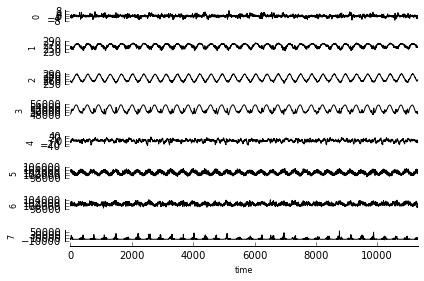

In [8]:
# Use the tigramite software to plot the timeseries

# Put the index into a list
var_names = cccmacmam.keys() #list(cam)
print(var_names)

# Plot the timeseries
tp.plot_timeseries(cccmacmam.as_matrix(columns=var_names[1::]),)
#                                                "qbo","sibslp","uralslp",
#                                                "vflux"]),
#                   var_names=allact_df.keys())

['date', 'NAO', 'BK-SIC', 'EA-tas', 'PoV', 'QBO', 'Sib-SLP', 'Ural-SLP', 'v_flux']
Index([u'date', u'NAO', u'BK-SIC', u'EA-tas', u'PoV', u'QBO', u'Sib-SLP',
       u'Ural-SLP', u'v_flux'],
      dtype='object')


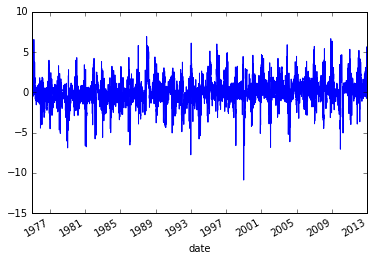

In [9]:
print(list(cam))
print(cam.keys()[:])
df = cam.copy()

df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].apply( lambda df : pd.datetime(year=df.year, 
                                                       month=df.month, 
                                                       day=df.day))
                                                       

  # set date column as index
df.set_index('date', inplace=True)

  # Create new column of months only
df['doy'] = df.index.dayofyear

# Get seasonal cycle, (transform keeps array the same size)
seascyc = df.groupby('doy').transform('mean')

  # Remove seasonal cycle, create anomaly actors dataframe
anomact = df - seascyc
#anomact.drop('day',axis=1,inplace=True)

  #detrend data
#for colname, col in anomact.iteritems():
    # print(colname)
#    anomact[colname] = signal.detrend(anomact[colname],axis=0)  

#print(anomact.head(n=3))

# Put data into tigramite dataframe

var_names=anomact.keys()
anomact_tdf = pp.DataFrame(anomact.as_matrix(columns=var_names[1::]))
  
#print(seascyc)

#df['EA-tas'][0:500].plot()
#seascyc['EA-tas'][0:500].plot()
anomact['EA-tas'].plot()

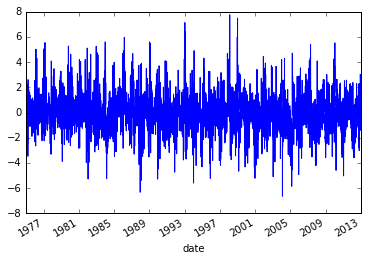

In [10]:
anomact['NAO'].plot()

### Remove seasonal cycle and detrend

In [11]:

def rm_seascyc(df):
  """
  Remove seasonal cycle and detrend data from a pandas dataframe, 
  then return the anomaly dataframe 
  and a Tigramite dataframe
  """
  
  # Remove time of day from date
  df['date'] = pd.to_datetime(df['date'])
  df['date'] = df['date'].apply( lambda df : pd.datetime(year=df.year, 
                                                         month=df.month, 
                                                         day=df.day))

  # set date column as index
  df.set_index('date', inplace=True)

  # Create new column of day of year
  df['DoY'] = df.index.dayofyear
  #df['mon'] = df.index.month

  # Get seasonal cycle, (transform keeps array the same size)
  seascyc = df.groupby('DoY').transform('mean')

  # Remove seasonal cycle, create anomaly actors dataframe
  anomact = df - seascyc
  anomact.drop('DoY',axis=1,inplace=True)

  #detrend data
  for colname, col in anomact.iteritems():
      #print(colname)
      anomact[colname] = signal.detrend(anomact[colname],axis=0)  

  #print(anomact.head(n=3))

  # Put data into tigramite dataframe

  var_names=anomact.keys()
  anomact_tdf = pp.DataFrame(anomact.as_matrix(columns=var_names[1::]))
  
  return anomact, seascyc

# Note: this doesn't work with NaN values
cam_anom, cam_seascyc = rm_seascyc(cam)
cccmacmam_anom, cccmacmam_seascyc = rm_seascyc(cccmacmam)
isac_cnrecham5sh_anom, isac_cnrecham5sh_seascyc = rm_seascyc(isac_cnrecham5sh)
mirocmiroc_agcm_anom, mirocmiroc_agcm_seascyc = rm_seascyc(mirocmiroc_agcm)
mirocmiroc_esm_anom, mirocmiroc_esm_seascyc = rm_seascyc(mirocmiroc_esm)
# mohcumga7_anom, mohcumga7_seascyc = rm_seascyc(mohcumga7)
# mrimri_esm2_anom, mrimri_esm2_seascyc = rm_seascyc(mrimri_esm2)
# waccm_anom, waccm_seascyc = rm_seascyc(waccm)
# yonseihadgem2_a_anom, yonseihadgem2_a_seascyc = rm_seascyc(yonseihadgem2_a)
# yonseihadgem2_ac_anom, yonseihadgem2_ac_seascyc = rm_seascyc(yonseihadgem2_ac)


Note: v_flux for CAM is of opposite sign to other models.

Also, the seasonal cycle of v_flux looks totally wrong for Miroc, Isac and MOHC. I'm not sure why, should look like this
https://acd-ext.gsfc.nasa.gov/Data_services/met/metdata/annual/merra2/flux/vt45_75n_100_2018_merra2.pdf

It seems the v_flux for CAM is for different years, at least the nectdf has different years, but that doesn't make any sense since it's meant to be forced with obs data, so it could just be the dates are wrong. I've checked the dates for the other models, they look fine. It looks like the seasonal cycle is just shifted, I guess it could be a processing issue to do dates but I'm not sure... Nick


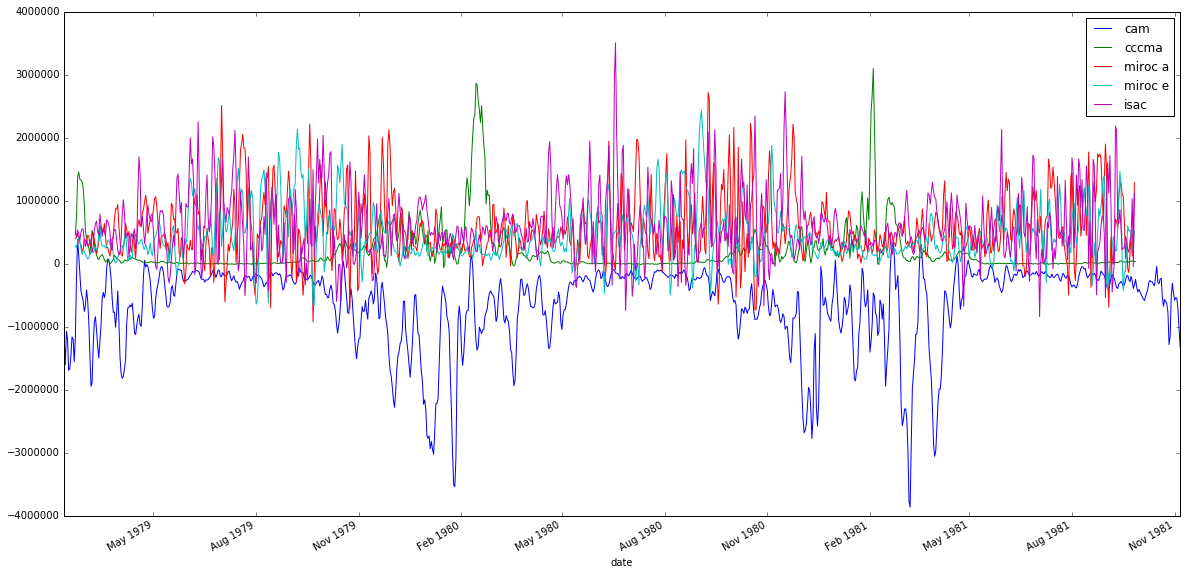

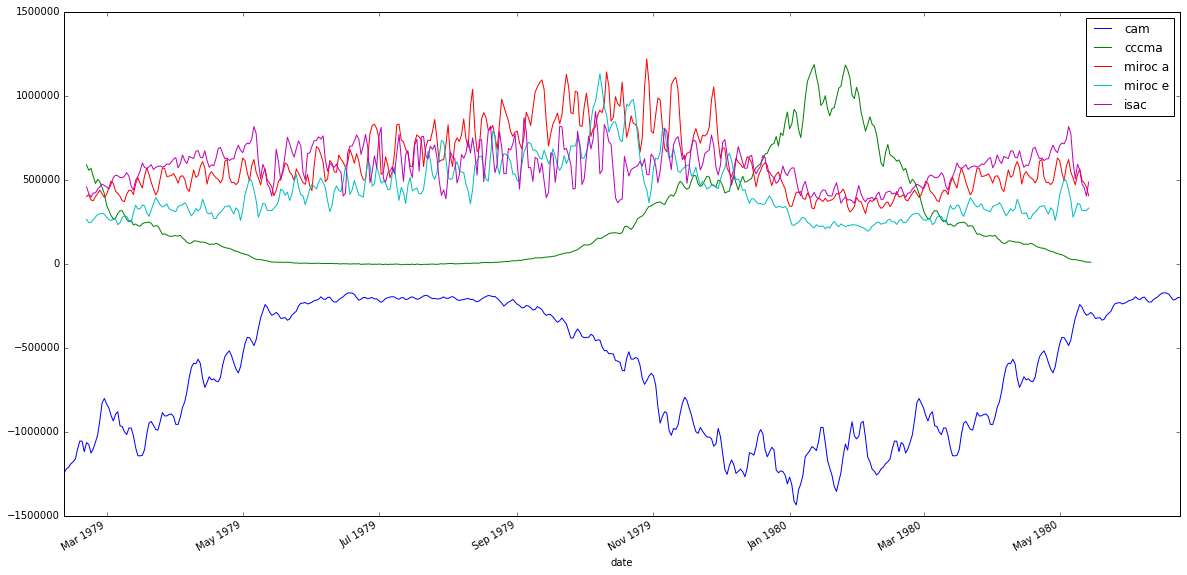

In [12]:
plt.figure(figsize=(20,10))
(cam['v_flux'][1500:2500]).plot(label='cam')
(cccmacmam['v_flux'][50:1000]*1e2).plot(label='cccma')
(mirocmiroc_agcm['v_flux'][50:1000]*1e1).plot(label='miroc a')
(mirocmiroc_esm['v_flux'][50:1000]*1e1).plot(label='miroc e')
#(mohcumga7['v_flux'][750:1500]*1e1).plot(label='mohc')
(isac_cnrecham5sh['v_flux'][50:1000]*1e1).plot(label='isac')
plt.legend()

plt.figure(figsize=(20,10))
(cam_seascyc['v_flux'][1500:2000]).plot(label='cam')
(cccmacmam_seascyc['v_flux'][50:500]*1e2).plot(label='cccma')
(mirocmiroc_agcm_seascyc['v_flux'][50:500]*1e1).plot(label='miroc a')
(mirocmiroc_esm_seascyc['v_flux'][50:500]*1e1).plot(label='miroc e')
#(mohcumga7_seascyc['v_flux'][750:1200]*1e1).plot(label='mohc')
(isac_cnrecham5sh_seascyc['v_flux'][50:500]*1e1).plot(label='isac')
plt.legend()

#### Reverse sign of CAM v_flux

Sign of CAM v_flux is opposite of other models.  Only run this once! Otherwise you will re-reverse

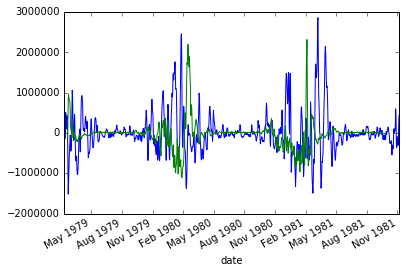

In [13]:
for rev_var in ['NAO','PoV','v_flux']:
#  cam_anom[rev_var] = cam_anom[rev_var]*(-1)
# cccmacmam_anom[rev_var] = cccmacmam_anom[rev_var]*(-1)
  isac_cnrecham5sh_anom[rev_var] = isac_cnrecham5sh_anom[rev_var]*(-1)
  mirocmiroc_agcm_anom[rev_var] = mirocmiroc_agcm_anom[rev_var]*(-1)
  mirocmiroc_esm_anom[rev_var] = mirocmiroc_esm_anom[rev_var]*(-1)
#  print("reversed: ")
#  print(rev_var)


cam_anom['v_flux'] = cam_anom['v_flux']*(-1)

(cam_anom['v_flux'][1500:2500]).plot(label='cam')
(cccmacmam_anom['v_flux'][50:1000]*1e2).plot(label='cccma')


In [14]:


def weekmean(df):
  n=0
  for colname, col in df.iteritems():
    #print(colname)
    #anomact[colname] = signal.detrend(anomact[colname],axis=0)  
    new_series = df[colname].resample('W').mean()
    new_series.name = colname
    if n==0:
      newdf = pd.DataFrame(new_series)
      n=1
    else:
      newdf[colname] = new_series
    
  return newdf
      
cam_week = weekmean(cam_anom)
cccmacmam_week = weekmean(cccmacmam_anom)
isac_cnrecham5sh_week = weekmean(isac_cnrecham5sh_anom)
mirocmiroc_agcm_week = weekmean(mirocmiroc_agcm_anom)
mirocmiroc_esm_week = weekmean(mirocmiroc_esm_anom)
#mohcumga7_week = weekmean(mohcumga7_anom)

cam_abs_week = weekmean(cam)
cccmacmam_abs_week = weekmean(cccmacmam)
isac_cnrecham5sh_abs_week = weekmean(isac_cnrecham5sh)
mirocmiroc_agcm_abs_week = weekmean(mirocmiroc_agcm)
mirocmiroc_esm_abs_week = weekmean(mirocmiroc_esm)
#mohcumga7_abs_week = weekmean(mohcumga7)


print(mirocmiroc_agcm_week)


              BK-SIC    EA-tas       NAO         PoV        QBO       Sib-SLP  \
date                                                                            
1979-01-07  0.937360  0.252376  0.948211  -44.492560   7.292457 -2.341958e+06   
1979-01-14  1.068919  0.714273  0.948063  -34.195397   9.345032 -2.340166e+06   
1979-01-21 -0.047743 -0.142643  0.947376  -51.201229  10.469729 -2.342496e+06   
1979-01-28 -0.602436  0.286756  0.945951  -42.551673  12.250780 -2.341289e+06   
1979-02-04 -1.220807  1.613479  0.945524  -23.830422  12.693560 -2.334350e+06   
1979-02-11  0.058851  2.126044  0.943885  -27.919189  13.954731 -2.332248e+06   
1979-02-18 -1.086982  2.001410  0.942896  -43.449662  13.518524 -2.331933e+06   
1979-02-25 -2.505605  1.902430  0.942407  -43.450268  14.808897 -2.322570e+06   
1979-03-04 -2.768770  1.251626  0.941729  -49.185109  14.920900 -2.323723e+06   
1979-03-11 -7.193878 -1.248494  0.940574  -39.392046  14.253172 -2.320492e+06   
1979-03-18 -9.341085  0.1298

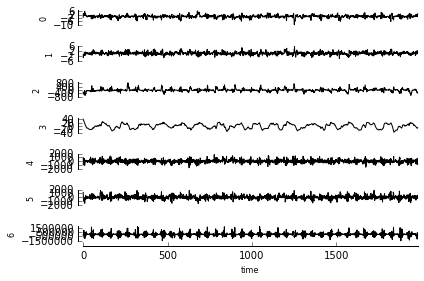

In [15]:

tp.plot_timeseries(cam_week.as_matrix(columns=var_names[1::]))


In [16]:
print(cam_week)

              BK-SIC    EA-tas       NAO         PoV        QBO      Sib-SLP  \
date                                                                           
1975-01-05  9.341141 -1.076635 -1.139281 -231.905819  41.157045   950.627243   
1975-01-12  0.102657  3.213511 -3.454526 -343.317582  36.708608  -966.844460   
1975-01-19  0.103569  2.737102 -2.154532 -444.404400  33.135485  -522.717158   
1975-01-26  5.828849  3.341261 -1.280223 -464.163992  32.449300   565.175591   
1975-02-02  5.334393  1.593244 -1.950297 -276.219998  29.964180   143.387558   
1975-02-09  4.448098  3.480163 -1.111972 -301.651864  25.846762  -238.368291   
1975-02-16  7.368076  2.479276  0.070149 -505.556622  23.268136   721.773627   
1975-02-23  6.523654  1.284349  0.801683 -404.623669  21.956912  -106.219244   
1975-03-02  9.293997  3.194014 -0.094974 -194.191885  20.719339   162.598014   
1975-03-09  0.161729  6.124707 -1.485570  -61.638819  17.569377 -1089.418509   
1975-03-16  4.538224  3.906886 -0.383719

### Create masks for QBOE and QBOW months. Include mask for months ONDJFM

In [17]:
# Mask data for QBOW, and create QBOW and QBOE dataframes

def qbomask(df_abs, df, u_lim=2):
  """
  Take a dataframe (df) with all timeseriees, put QBO into seperate df,
  make masks with the QBO data.
  Uses a threshold of +/- 5 m/s for u-wind, unless otherwise specified.
  Input: dataframe of anomalies
  Output: dataframe w/o QBO, df of QBO, mask for QBOE, mask for QBOW, 
          mask for no qbo, i.e. mask of months ONDJFM
  """
  
  # Put QBO timeseries in a seperate df and create QBOE/W df
  df_qbo = df_abs[['QBO']].copy() # Use abs values to calc QBO
  df_noqbo = df.drop('QBO',axis=1)
  
  # Add month series
  df_noqbo['mon'] = df_noqbo.index.month
  
  # Set up masked arrays
  mask_qbow = np.zeros(df_qbo.shape).astype('bool')
  mask_qboe = np.zeros(df_qbo.shape).astype('bool')
  mask_mon = np.zeros(df_qbo.shape).astype('bool')
  
  # Create QBOW Mask for given u_lim
  mask_qbow = np.ma.masked_less(df_qbo.as_matrix(columns=['QBO']),u_lim).mask
  # Make mask same size as full df
  df_size = df_noqbo.shape[1]
  mask_qbow2 = np.tile(mask_qbow,df_size)
  # Repeat for QBOE
  mask_qboe = np.ma.masked_greater(df_qbo.as_matrix(columns=['QBO']),-u_lim).mask
  mask_qboe2 = np.tile(mask_qboe,df_size)

  # Create Mask for Months Oct-Mar (i.e. mask out all other months)
  mask_mon[:,0] = ((df_noqbo['mon'] == 4) | (df_noqbo['mon'] == 5) |
                 (df_noqbo['mon'] == 6) | (df_noqbo['mon'] == 7) |
                 (df_noqbo['mon'] == 8) | (df_noqbo['mon'] == 9)).as_matrix()

  mask_mon2 = np.tile(mask_mon,df_size) #.reshape(mask_qboe2.shape)

  # Add month mask to QBO masks
  mask_qboe_mon = mask_qboe2 + mask_mon2
  mask_qbow_mon = mask_qbow2 + mask_mon2

  # Use QBO masks on data
  #  df_qboe.mask(mask_qboe2,inplace=True)
  #  df_qbow.mask(mask_qbow2,inplace=True)
  
  return(df_noqbo, df_qbo, mask_qboe_mon, mask_qbow_mon, mask_mon2)

cam_noqbo, cam_qbo, cam_qboe_mask, cam_qbow_mask, cam_noqbo_mask = qbomask(cam_abs_week,cam_week)
cccmacmam_noqbo, cccmacmam_qbo, cccmacmam_qboe_mask, cccmacmam_qbow_mask, cccmacmam_noqbo_mask = qbomask(cccmacmam_abs_week,cccmacmam_week)
isac_cnrecham5sh_noqbo, isac_cnrecham5sh_qbo, isac_cnrecham5sh_qboe_mask, isac_cnrecham5sh_qbow_mask, isac_cnrecham5sh_noqbo_mask = qbomask(isac_cnrecham5sh_abs_week,isac_cnrecham5sh_week)
mirocmiroc_agcm_noqbo, mirocmiroc_agcm_qbo, mirocmiroc_agcm_qboe_mask, mirocmiroc_agcm_qbow_mask, mirocmiroc_agcm_noqbo_mask = qbomask(mirocmiroc_agcm_abs_week,mirocmiroc_agcm_week)
mirocmiroc_esm_noqbo, mirocmiroc_esm_qbo, mirocmiroc_esm_qboe_mask, mirocmiroc_esm_qbow_mask, mirocmiroc_esm_noqbo_mask = qbomask(mirocmiroc_esm_abs_week,mirocmiroc_esm_week)
#mohcumga7_noqbo, mohcumga7_qbo, mohcumga7_qboe_mask, mohcumga7_qbow_mask, mohcumga7_noqbo_mask = qbomask(mohcumga7_abs_week,mohcumga7_week)
#mrimri_esm2_noqbo, mrimri_esm2_qbo, mrimri_esm2_qboe_mask, mrimri_esm2_qbow_mask, mrimri_esm2_noqbo_mask = qbomask(mrimri_esm2_abs_week,mrimri_esm2_week)
#waccm_noqbo, waccm_qbo, waccm_qboe_mask, waccm_qbow_mask, waccm_noqbo_mask = qbomask(waccm_abs_week,waccm_week)
#yonseihadgem2_a_noqbo,yyonseihadgem2_a_qbo,yonseihadgem2_a_qboe_mask, yonseihadgem2_a_qbow_mask, yonseihadgem2_a_noqbo_mask = qbomask(yonseihadgem2_a_abs_week,yonseihadgem2_a_week)
#yonseihadgem2_ac_noqbo, yonseihadgem2_ac_qbo, yonseihadgem2_ac_qboe_mask, yonseihadgem2_ac_qbow_mask, yonseihadgem2_ac_noqbo_mask = qbomask(yonseihadgem2_ac_abs_week,yonseihadgem2_ac_week)




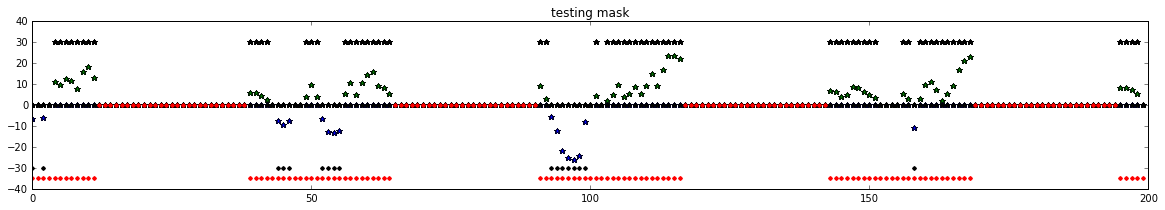

In [18]:
#tp.plot_timeseries(cam_anom.as_matrix(columns=var_names[1::]),mask=cam_qboe_mask)
#tp.plot_timeseries(cam_anom.as_matrix(columns=var_names[1::]))

#print(cam_noqbo_mask.shape)
#print(cam_qboe_mask.shape)
plt.figure(figsize=(20,3))
#plt.plot(cam_qbow_mask[0:100]*10,'b')
#plt.plot(cam_qbo.as_matrix()[0:100])
#plt.plot(cam_qbo.as_matrix()[0:200]*(~cam_qbow_mask[0:200]).astype('int'),'k*')
#plt.plot(cam_qbo.as_matrix()[0:200]*(~cam_qboe_mask[0:200]).astype('int'),'r*')
plt.plot(cccmacmam_qbo.as_matrix()[0:200]*(~cccmacmam_qbow_mask[0:200]).astype('int'),'g*')
plt.plot(cccmacmam_qbo.as_matrix()[0:200]*(~cccmacmam_qboe_mask[0:200]).astype('int'),'b*')
plt.plot(~cccmacmam_qbow_mask[0:200]*30,'k*')
plt.plot(~cccmacmam_qboe_mask[0:200]*(-30),'k.')
plt.plot(~cccmacmam_noqbo_mask[0:200]*(-35),'r.')
#plt.plot(cam_qboe_mask[0:50])
#plt.plot(cam_noqbo_mask[0:100]*10,'r')
plt.ylim(-40,40)

plt.title('testing mask')

## Plotting

### Plot all models

#### Function for plotting

In [19]:

def run_and_plot(dataframe, cond_ind_test, fig_ax, var_select):
    """
    small function from example notebook to calc pcmci and plot masked links
    
    """
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, var_names=var_select)
    results = pcmci.run_pcmci(tau_min=0,tau_max=4,pc_alpha=0.4)
    link_matrix = pcmci._return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
    tp.plot_graph(fig_ax = fig_ax,  val_matrix=results['val_matrix'],
                  link_matrix=link_matrix, var_names=var_select,
    )
    return

def plot_model(df_noqbo,mon_mask,qboe_mask,qbow_mask,var_select,mask_type=None,
               save_plot=False,save_name=None,save_qbo=False,title=None):
               #var_names=['AO','BK-tas','EA-tas','PoV','Sib-SLP','Ural-SLP',
               #           'v_flux']):
    """
    Function to plot three link matrices, for all years, qboe and qbow, for selected
    variables
    Input:
    df_noqbo  = pandas dataframe of timeseries (without qbo)
    mon_mask  = masked array of months ONDJFM
    qboe_mask = masked array of QBOE, same dimensions as data
    qbow_mask = masked array of QBOW, same dimensions as data
    var_names = list of variables for link matrix
    mask_type = masking mode, 'y','x','z','yz','xy','xz','xyz', if None,'y' used
    save_name = name to save plot, if None then not saved

    """
    print(var_select)
    df_names=df_noqbo[var_select]
    n_cols = len(var_select)

    tig_df_all = pp.DataFrame(df_names.as_matrix(columns=var_select),
                             mask=mon_mask[:,0:n_cols])
    tig_df_qboe = pp.DataFrame(df_names.as_matrix(columns=var_select),
                             mask=qboe_mask[:,0:n_cols])
    tig_df_qbow = pp.DataFrame(df_names.as_matrix(columns=var_select),
                             mask=qbow_mask[:,0:n_cols])

    # Causal graph all QBO years
    print("All years")
    fig = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111); plt.title("All, {}".format(title))
    run_and_plot(tig_df_all, ParCorr(significance='analytic',use_mask=True, mask_type=mask_type), (fig, ax), var_select=var_select)

    current_var = "_".join(var_select)
    if save_plot:
        fig.savefig('{}_all_day_{}.png'.format(save_name,current_var), bbox_inches='tight')
        figfile = drive.CreateFile({'title':'{}_all_day_{}.png'.format(save_name,current_var),
                                'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
        figfile.SetContentFile('{}_all_day_{}.png'.format(save_name,current_var))
        figfile.Upload()

    """
    # # Causal graph, QBOE
    print("QBOE years")
    fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111);  plt.title("QBOE, {}".format(title))
    run_and_plot(tig_df_qboe, ParCorr(significance='analytic',use_mask=True, mask_type=mask_type), (fig, ax), var_select=var_select)

    if save_plot and save_qbo:
    fig.savefig('{}_qboe_day_{}.png'.format(save_name,current_var), bbox_inches='tight')
    figfile = drive.CreateFile({'title':'{}_qboe_day_{}.png'.format(save_name,current_var),
                                'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
    figfile.SetContentFile('{}_qboe_day_{}.png'.format(save_name,current_var))
    figfile.Upload()  

    # # Causal graph, QBOW
    print("QBOW years")
    fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111);  plt.title("QBOW, {}".format(title))
    run_and_plot(tig_df_qbow, ParCorr(significance='analytic',use_mask=True, mask_type=mask_type), (fig, ax), var_select=var_select)

    if save_plot and save_qbo:
    fig.savefig('{}_qbow_day_{}.png'.format(save_name,current_var), bbox_inches='tight')
    figfile = drive.CreateFile({'title':'{}_qbow_day_{}.png'.format(save_name,current_var),
                                'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
    figfile.SetContentFile('{}_qbow_day_{}.png'.format(save_name,current_var))
    figfile.Upload()
    """
    return



-----------------------------------------------------
CAM
['NAO', 'PoV', 'v_flux']
All years


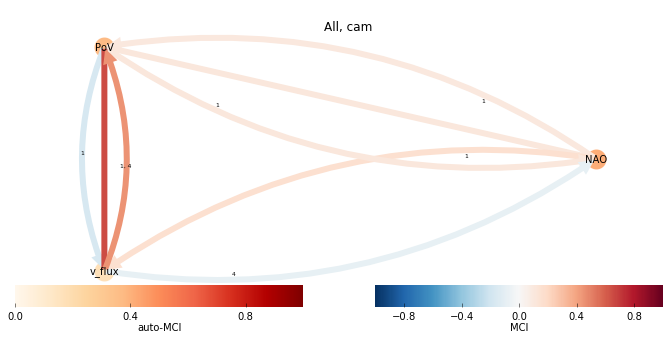

-----------------------------------------------------
CCCMA
['NAO', 'PoV', 'v_flux']
All years


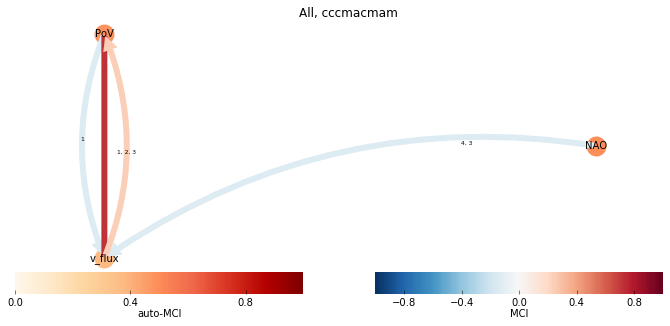

-----------------------------------------------------
ISAC
['NAO', 'PoV', 'v_flux']
All years


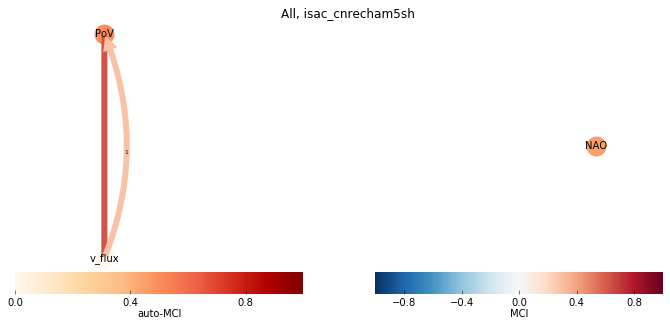

-----------------------------------------------------
MIROC AGCM
['NAO', 'PoV', 'v_flux']
All years


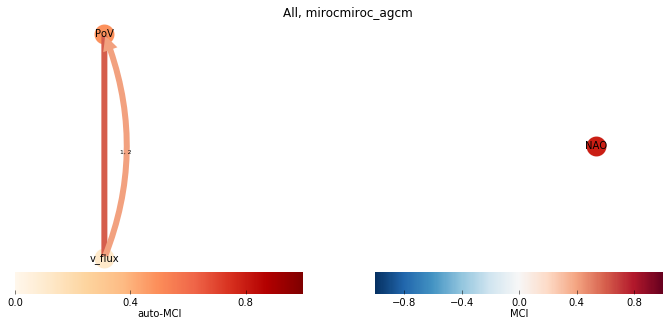

-----------------------------------------------------
MIROC ESM
['NAO', 'PoV', 'v_flux']
All years


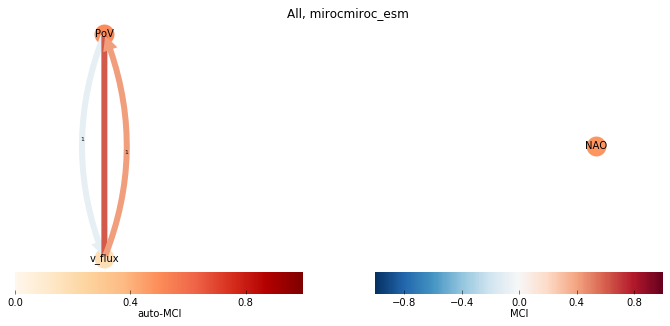

-----------------------------------------------------


'\nprint("MOHC")\nplot_model(mohcumga7_noqbo,mohcumga7_noqbo_mask,mohcumga7_qboe_mask,mohcumga7_qbow_mask,\n           var_select=var_select,save_plot=save_plot,save_name="mohcumga7",title="mohcumga7")\nprint("-----------------------------------------------------")\nprint("MRI")\nplot_model(mrimri_esm2_noqbo,mrimri_esm2_noqbo_mask,mrimri_esm2_qboe_mask,mrimri_esm2_qbow_mask,\n           var_select=var_select,save_plot=save_plot,save_name="mrimri_esm2",title="mrimri_esm2")\nprint("-----------------------------------------------------")\nprint("WACCM")\nplot_model(waccm_noqbo,waccm_noqbo_mask,waccm_qboe_mask,waccm_qbow_mask,\n           var_select=var_select,save_plot=save_plot,save_name="waccm",title="waccm")\nprint("-----------------------------------------------------")\nprint("YONSEI A")\nplot_model(yonseihadgem2_a_noqbo,yonseihadgem2_a_noqbo_mask,yonseihadgem2_a_qboe_mask,yonseihadgem2_a_qbow_mask,\n           var_select=var_select,save_plot=save_plot,save_name="yonseihadgem2_a",tit

In [28]:
# All available variable names:
# var_names=['NAO','BK-tas','EA-tas','PoV','Sib-SLP','Ural-SLP','v_flux']

save_plot=False #True # set to True/False to save the plots to drive folder

# var_select=['NAO','PoV','v_flux']

var_select=['NAO','BK-tas','EA-tas','PoV','Sib-SLP','Ural-SLP','v_flux']
var_select=['NAO','PoV','v_flux']


print("-----------------------------------------------------")
print("CAM")
plot_model(cam_noqbo,cam_noqbo_mask,cam_qboe_mask,cam_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="cam", title="cam")
print("-----------------------------------------------------")
print("CCCMA")
plot_model(cccmacmam_noqbo,cccmacmam_noqbo_mask,cccmacmam_qboe_mask,cccmacmam_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="cccmacmam",title="cccmacmam")
print("-----------------------------------------------------")
print("ISAC")
plot_model(isac_cnrecham5sh_noqbo,isac_cnrecham5sh_noqbo_mask,isac_cnrecham5sh_qboe_mask,isac_cnrecham5sh_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="isac_cnrecham5sh",title="isac_cnrecham5sh")
print("-----------------------------------------------------")
print("MIROC AGCM")
plot_model(mirocmiroc_agcm_noqbo,mirocmiroc_agcm_noqbo_mask,mirocmiroc_agcm_qboe_mask,mirocmiroc_agcm_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mirocmiroc_agcm",title="mirocmiroc_agcm")
print("-----------------------------------------------------")
print("MIROC ESM")
plot_model(mirocmiroc_esm_noqbo,mirocmiroc_esm_noqbo_mask,mirocmiroc_esm_qboe_mask,mirocmiroc_esm_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mirocmiroc_esm",title="mirocmiroc_esm")
print("-----------------------------------------------------")
"""
print("MOHC")
plot_model(mohcumga7_noqbo,mohcumga7_noqbo_mask,mohcumga7_qboe_mask,mohcumga7_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mohcumga7",title="mohcumga7")
print("-----------------------------------------------------")
print("MRI")
plot_model(mrimri_esm2_noqbo,mrimri_esm2_noqbo_mask,mrimri_esm2_qboe_mask,mrimri_esm2_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mrimri_esm2",title="mrimri_esm2")
print("-----------------------------------------------------")
print("WACCM")
plot_model(waccm_noqbo,waccm_noqbo_mask,waccm_qboe_mask,waccm_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="waccm",title="waccm")
print("-----------------------------------------------------")
print("YONSEI A")
plot_model(yonseihadgem2_a_noqbo,yonseihadgem2_a_noqbo_mask,yonseihadgem2_a_qboe_mask,yonseihadgem2_a_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="yonseihadgem2_a",title="yonseihadgem2_a")
print("-----------------------------------------------------")
print("YONSEI AC")
plot_model(yonseihadgem2_ac_noqbo,yonseihadgem2_ac_noqbo_mask,yonseihadgem2_ac_qboe_mask,yonseihadgem2_ac_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="yonseihadgem2_ac",title="yonseihadgem2_ac")
"""

### Ensemble mean plots


The code  below calculates the link matrices for all models, then combines them. You can change the models used by changing the "mods" list. Change the actors used by changing the var_select list. Rerun the two cells below to see the changes.



In [21]:
# Function for ensemble plots


def run_and_plot_prepare_ensemble(dataframe, cond_ind_test, var_select, tau_max,
                                  tau_min, pc_alpha=0.4):
    """
    small function from example notebook to calc pcmci and plot masked links
    
    """
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, var_names=var_select)
    results = pcmci.run_pcmci(tau_min=tau_min,tau_max=tau_max,pc_alpha=pc_alpha)
    link_matrix = pcmci._return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
# #     tp.plot_graph(fig_ax = fig_ax,  val_matrix=results['val_matrix'],
# #                   link_matrix=link_matrix, var_names=var_select,
#     )
    return results, link_matrix




In [22]:
### WORKING QBOE/W MASK
### 

mods = [cam_noqbo,cccmacmam_noqbo,isac_cnrecham5sh_noqbo,mirocmiroc_agcm_noqbo,
        mirocmiroc_esm_noqbo]
        #,mohcumga7_noqbo]
        #,mrimri_esm2_noqbo,waccm_noqbo,
        #yonseihadgem2_a_noqbo,yonseihadgem2_ac_noqbo]

qemask = [cam_qboe_mask, cccmacmam_qboe_mask, isac_cnrecham5sh_qboe_mask, mirocmiroc_agcm_qboe_mask,
        mirocmiroc_esm_qboe_mask]
          #,mohcumga7_qboe_mask]
        #,mrimri_esm2_qboe_mask,waccm_qboe_mask,
        #yonseihadgem2_a_qboe_mask,yonseihadgem2_ac_qboe_mask]
qwmask = [cam_qbow_mask, cccmacmam_qbow_mask, isac_cnrecham5sh_qbow_mask, mirocmiroc_agcm_qbow_mask,
        mirocmiroc_esm_qbow_mask]
          #,mohcumga7_qbow_mask]
        #,mrimri_esm2_qbow_mask,waccm_qbow_mask,
        #yonseihadgem2_a_qbow_mask,yonseihadgem2_ac_qbow_mask]
monmask = [cam_noqbo_mask, cccmacmam_noqbo_mask, isac_cnrecham5sh_noqbo_mask, mirocmiroc_agcm_noqbo_mask,
        mirocmiroc_esm_noqbo_mask]
           #,mohcumga7_noqbo_mask]
        #,mrimri_esm2_noqbo_mask,waccm_noqbo_mask,
        #yonseihadgem2_a_noqbo_mask,yonseihadgem2_ac_noqbo_mask]

var_select=['NAO','BK-SIC','EA-tas','PoV','Sib-SLP','Ural-SLP','v_flux'] # ['BK-tas','EA-tas','PoV','v_flux','Sib-SLP']
var_select=['PoV','NAO','v_flux'] #,'EA-tas']

current_var = "_".join(var_select)
print("Current variables: {}".format(current_var))
#var_select=['PoV','Sib-SLP','v_flux']
# all variable names: ['NAO','BK-tas','EA-tas','PoV','Sib-SLP','Ural-SLP','v_flux']


# Change these variables
tau_max = 4         # Maximum lag
tau_min = 0         # Minimum lag
robust_thres = .4   #Only show links that are significant in that fraction of models
alpha_level = 0.01

n_models = len(mods)
n_cols = len(var_select)

link_matrices_all = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_all = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
link_matrices_qe = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_qe = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
link_matrices_qw = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_qw = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))

for i in range(n_models):
    print(i)
    # Initialize dataframe object
    data = mods[i].as_matrix(columns=var_select)
    
    df_all = pp.DataFrame(data,mask=monmask[i][:,0:n_cols])
    df_qbow = pp.DataFrame(data, mask=qwmask[i][:,0:n_cols])
    df_qboe = pp.DataFrame(data, mask=qemask[i][:,0:n_cols])
    
    print('results all')
    results_all, link_matrix_all = run_and_plot_prepare_ensemble(df_all, 
                                      ParCorr(significance='analytic',use_mask=True),
                                      var_select=var_select, tau_max=tau_max,
                                      tau_min=tau_min,pc_alpha=0.4)
    print('results qboe')
    results_qboe, link_matrix_qboe = run_and_plot_prepare_ensemble(df_qboe,
                                      ParCorr(significance='analytic',use_mask=True),
                                      var_select=var_select, tau_max=tau_max,
                                      tau_min=tau_min)
    results_qbow, link_matrix_qbow = run_and_plot_prepare_ensemble(df_qbow,
                                      ParCorr(significance='analytic',use_mask=True),
                                      var_select=var_select, tau_max=tau_max,
                                      tau_min=tau_min)

    link_matrices_all[i] = link_matrix_all
    average_vals_all[i] = results_all['val_matrix']
    link_matrices_qw[i] = link_matrix_qbow
    average_vals_qw[i] = results_qbow['val_matrix']
    link_matrices_qe[i] = link_matrix_qboe
    average_vals_qe[i] = results_qboe['val_matrix']


print("ALL YEARS")
link_color_matrix_all = average_vals_all.mean(axis=0)
link_width_all = link_matrices_all.mean(axis=0)
link_matrix_all = link_width_all > robust_thres

print("QBOW YEARS")
link_color_matrix_qw = average_vals_qw.mean(axis=0)
link_width_qw = link_matrices_qw.mean(axis=0)
link_matrix_qw = link_width_qw > robust_thres

print("QBOE YEARS")
link_color_matrix_qe = average_vals_qe.mean(axis=0)
link_width_qe = link_matrices_qe.mean(axis=0)
link_matrix_qe = link_width_qe > robust_thres


Current variables: PoV_NAO_v_flux
0
results all
results qboe
1
results all
results qboe
2
results all
results qboe
3
results all
results qboe
4
results all
results qboe
ALL YEARS
QBOW YEARS
QBOE YEARS


ALL YEARS


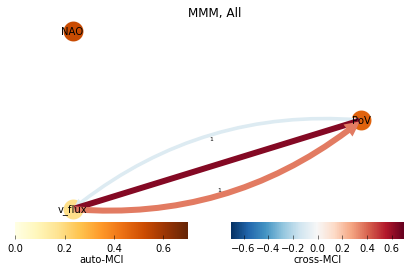

QBOW YEARS


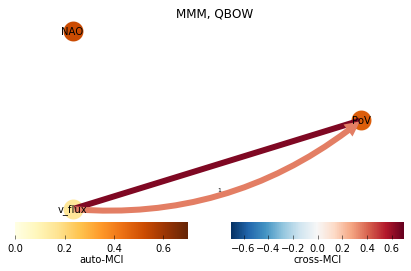

QBOE YEARS


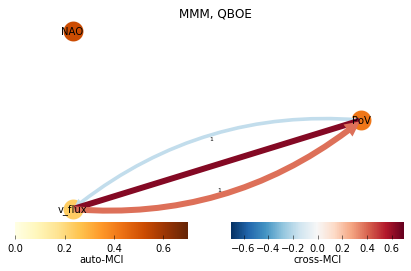

QBO DIFF: QBOE - QBOW


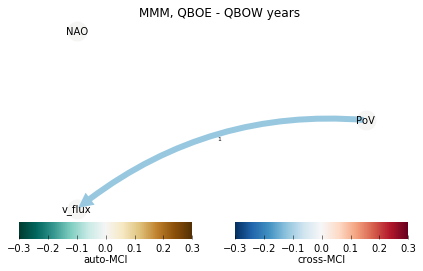

In [23]:

## PLOT ENSEMBLE PLOTS

# FIGURE PROPERTIES

savefig = False # Save figures in the google drive, True or False

vmax_edges=0.7; vmin_edges=-0.7
vmax_nodes=0.7; vmin_nodes=0.0
edge_ticks=0.2; node_ticks=0.2
cmap_nodes='YlOrBr'; cmap_edges='RdBu_r'
    

fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
plt.title("MMM, All")
print("ALL YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_all,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_all,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_all,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges
    )

if savefig:
  fig.savefig('ens_week_all_{}.png'.format(current_var), bbox_inches='tight')
  figfile = drive.CreateFile({'title':'ens_week_all_{}.png'.format(current_var),
                              'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
  figfile.SetContentFile('ens_week_all_{}.png'.format(current_var))
  figfile.Upload()


fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOW")
print("QBOW YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qw,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_qw,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qw,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges
    )

if savefig:
  fig.savefig('ens_week_qbo_w_{}.png'.format(current_var), bbox_inches='tight')
  figfile = drive.CreateFile({'title':'ens_week_qbo_w_{}.png'.format(current_var),
                              'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
  figfile.SetContentFile('ens_week_qbo_w_{}.png'.format(current_var))
  figfile.Upload()


fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOE")
print("QBOE YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qe,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_qe,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qe,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges
    )

if savefig:
  fig.savefig('ens_week_qbo_e_{}.png'.format(current_var), bbox_inches='tight')
  figfile = drive.CreateFile({'title':'ens_week_qbo_e_{}.png'.format(current_var),
                              'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
  figfile.SetContentFile('ens_week_qbo_e_{}.png'.format(current_var))
  figfile.Upload()

## PLOT ENSEMBLE PLOTS for difference between QBOE-QBOW
fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)

link_color_matrix_diff = link_color_matrix_qe - link_color_matrix_qw
link_matrix_diff = link_matrix_qe ^ link_matrix_qw
link_width_diff = np.abs(link_width_qe - link_width_qw)

fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOE - QBOW years")
print("QBO DIFF: QBOE - QBOW")
tp.plot_graph(
    val_matrix=link_color_matrix_diff,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_diff,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmax_edges=0.3,
    vmin_edges=-0.3,
    edge_ticks=0.1,
    node_ticks=0.1,
    vmax_nodes=0.3,
    vmin_nodes=-0.3,
    cmap_nodes='BrBG_r',
    cmap_edges='RdBu_r'
    )

if savefig:
  fig.savefig('ens_week_qbo_diff_{}.png'.format(current_var), bbox_inches='tight')
  figfile = drive.CreateFile({'title':'ens_week_qbo_diff_{}.png'.format(current_var),
                              'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
  figfile.SetContentFile('ens_week_qbo_diff_{}.png'.format(current_var))
  figfile.Upload()

QBOE - QBOW


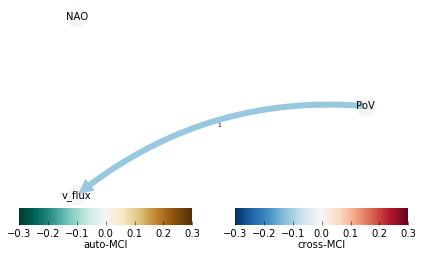

In [24]:
## PLOT ENSEMBLE PLOTS for difference between QBOE-QBOW
fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)

link_color_matrix_diff = link_color_matrix_qe - link_color_matrix_qw
link_matrix_diff = link_matrix_qe ^ link_matrix_qw
link_width_diff = np.abs(link_width_qe - link_width_qw)

fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
print("QBOE - QBOW")
tp.plot_graph(
    val_matrix=link_color_matrix_diff,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_diff,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmax_edges=0.3,
    vmin_edges=-0.3,
    edge_ticks=0.1,
    node_ticks=0.1,
    vmax_nodes=0.3,
    vmin_nodes=-0.3,
    cmap_nodes='BrBG_r',
    cmap_edges='RdBu_r'
    )

#fig.savefig('ens_qbo_w_{}.png'.format(current_var), bbox_inches='tight')
#figfile = drive.CreateFile({'title':'ens_qbo_w_{}.png'.format(current_var),
#                            'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
#figfile.SetContentFile('ens_qbo_w_{}.png'.format(current_var))
#figfile.Upload()



In the code below I attempted to plot three plots on one figure. Passed the fig and ax to plotting function, but doesn't behave how I'd expect - Nick

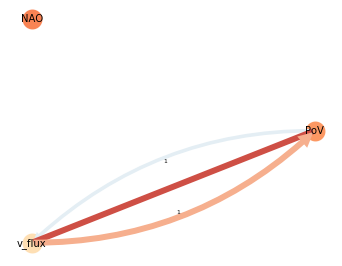

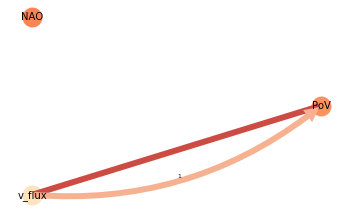

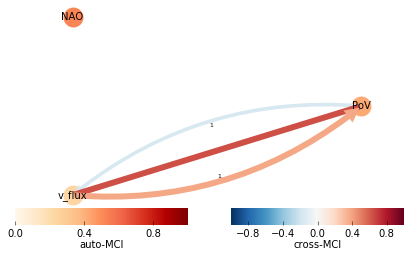

In [25]:
## PLOT ENSEMBLE PLOTS
fig = plt.figure(figsize=(20,5))

#fig = plt.gcf()
ax1 = fig.add_subplot(1,3,1, frameon=False) # should have 1 row, with 3 columns
#ax1 = plt.gca()
#print("ALL YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_all,
    fig_ax=(fig,ax1),
    link_matrix=link_matrix_all,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_all,
    show_colorbar=False
    )


#fig = plt.gcf()
ax2 = fig.add_subplot(1,3,2, frameon=False)
ax2 = plt.gca()
#print("QBOW YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qw,
    fig_ax=(fig,ax2),
    link_matrix=link_matrix_qw,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qw,
    show_colorbar=False
    )

#fig = plt.gcf()
ax3 = fig.add_subplot(1,3,3, frameon=False)
ax3 = plt.gca()
#print("QBOE YEARS")

out = tp.plot_graph(
    val_matrix=link_color_matrix_qe,
    fig_ax=(fig,ax3),
    link_matrix=link_matrix_qe,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qe,
    show_colorbar=True
    )


#print(type(out))
#print(type(fig))
#fig.savefig('ens_qbo_e.png', bbox_inches='tight')
#figfile = drive.CreateFile({'title':'ens_qbo_e.png',
#                            'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
#figfile.SetContentFile('ens_qbo_e.png')
#figfile.Upload()

In [26]:
#Example to save a figure to file
#it will be save in the personal downloads so still need to upload it back to the drive
#import matplotlib.pyplot as plt
#from google.colab import files
#fig = plt.figure()
#ax = fig.add_axes([1,1,1,1])
#plt.plot([1,2])
#plt.savefig('abc.png', bbox_inches='tight')
#files.download("abc.png") 